In [287]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [374]:
def f(c):
    if c == 'Czechia':
        return 'Czech Republic'
    elif c == 'Slovakia':
        return 'Slovak Republic'
    return c

def gatherings(n):
    if n == np.nan:
        return 0
    return 1/(1+np.exp(3-np.log(n)))


In [375]:
# Want to know where Oxford records a higher value

OX2FEATS = {
    'S6':{(2,0):[('Asymptomatic isolation - blanket',1)],
          (2,1):[('Asymptomatic isolation - blanket',2),
                 ('Domestic travel restriction',2)],
          (1,0):[('Domestic travel restriction',1)],
          (1,1):[('Public interaction and hygiene',1)]},
    'S7':{1:[('International travel restriction',1)],
         2:[('International travel restriction',3)],
         3:[('International travel restriction',3)]},
    'S5':{(1,0):[('Public education and incentives',1)],
         (1,1):[('Public education and incentives',2)]},
    'S3':{(2,1):[('Gatherings banned',1)],
         (2,0):[('Activity cancellation',1)]},
    'S2':{(2,0):[('Nonessential business suspension',1)],
         (2,1):[('Nonessential business suspension',2)]},
    'S1':{(2,1):[('School closure',1)]}    
}

def get_feats(k):
    return pd.Series([f[0] for k,v in O2F[k].items() for f in v]).unique()

def get_values(k):
    pos = {f:i for i,f in enumerate(get_feats(k))}
    l = [np.nan]*len(get_feats(k))
    def gv(p):
        try:
            for c,v in O2F[k][p]:
                l[pos[c]] = v
        except KeyError:
            pass
        return l
    return gv

def ox2feats(df_ox):
    for f in ['Asymptomatic isolation - blanket',
              'Domestic travel restriction',
              'Public interaction and hygiene',
              'International travel restriction',
              'Public education and incentives',
              'Gatherings banned',
              'Activity cancellation',
              'Nonessential business suspension',
              'School closure']:
        df_ox[f]=np.nan
    for k in O2F:
        k1 = df_ox.columns[df_ox.columns.str.startswith(k)][0]
        k2 = k+'_IsGeneral'
        if k2 in df_ox.columns:
            pairs = list(zip(df_ox[k1],ox[k2].values))
            df_ox[get_feats(k)] = [get_values(k)(p) for p in pairs]
        else:
            singles = list(df_ox[k1].values)
            df_ox[get_feats(k)] = [get_values(k)(p) for p in singles]
    
def dashify(d):
    d = str(d)
    return d[:4]+'-'+d[4:6]+'-'+d[6:]
    

In [415]:
ox = pd.read_excel('OxCGRT_Download_latest_data.xlsx')
feats = pd.read_csv('countermeasures_features_2020_04_06.csv')
feats['Date'] = pd.to_datetime(feats['Date'])
ox.loc[:,'Date'] = ox['Date'].apply(dashify)
ox['Date'] = pd.to_datetime(ox['Date'])
ox = ox.rename(columns={'CountryName':'Country'})

feats['Country'] = feats['Country'].apply(f)
ox2feats(ox)
cmp = ['Asymptomatic isolation - blanket',
#       'Domestic travel restriction',
      'Public interaction and hygiene',
#       'International travel restriction',
#       'Public education and incentives',
      'Gatherings banned',
      'Activity cancellation',
      'Nonessential business suspension',
      'School closure']

compare = ox[ox['Country'].isin(feats['Country'])][['Country',
              'Date'] + cmp].copy()
feats_c = feats[(feats['Date']>=pd.Timestamp('2020-01-01'))&(feats['Date']<=pd.Timestamp('2020-03-31'))]
feats_c['Gatherings banned'] = feats_c['Gatherings banned'].apply(gatherings)
mg = pd.merge(left=compare,right=feats_c, on=['Country','Date'],suffixes=('_ox','_ef'))

cmp_ox = mg.columns.str.endswith('_ox')
cmp_ef = mg.columns.str.endswith('_ef')

/home/guest/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [416]:
mg[(mg.fillna(0).loc[:,cmp_ef].values - mg.fillna(0).loc[:,cmp_ox].values<0).any(1)].to_csv('in_oxford.csv')
mg[(mg.fillna(0).loc[:,cmp_ef].values - mg.fillna(0).loc[:,cmp_ox].values>0).any(1)].to_csv('in_ef.csv')

In [417]:
fd_bool = (mg.fillna(0).loc[:,cmp_ef].values>0).astype(int)
cgrt_bool = (mg.fillna(0).loc[:,cmp_ox].values>0).astype(int)

In [418]:
((cgrt_bool-fd_bool)<0).any(1).sum()

1588

In [419]:
((cgrt_bool-fd_bool)>0).any(1).sum()

753

In [420]:
((cgrt_bool-fd_bool)==0).all(1).sum()

3150

In [380]:
2111/4940

0.42732793522267204

In [403]:
len(mg[((mg.fillna(0).loc[:,cmp_ef].values - mg.fillna(0).loc[:,cmp_ox].values)==0).all(1)])

2014

In [402]:
len(mg[((mg.fillna(0).loc[:,cmp_ef].values - mg.fillna(0).loc[:,cmp_ox].values)>0).any(1)])

2069

In [398]:
mg.columns[cmp_ox]

Index(['Asymptomatic isolation - blanket_ox', 'Domestic travel restriction_ox',
       'Public interaction and hygiene_ox',
       'International travel restriction_ox',
       'Public education and incentives_ox', 'Gatherings banned_ox',
       'Activity cancellation_ox', 'Nonessential business suspension_ox',
       'School closure_ox'],
      dtype='object')

In [317]:
raw = ox.loc[:,(ox.columns.str.startswith('S')|ox.columns.isin(['Date','Country']))&
       (~ox.columns.str.endswith('_IsGeneral'))&
       (~ox.columns.str.endswith('_Notes'))&
       (~ox.columns.str.endswith('Index'))&
       (~ox.columns.str.endswith('closure'))]
mg2 = pd.merge(left=raw,right=feats_c, on=['Country','Date'],suffixes=('_ox','_ef'))


In [331]:
co = mg2.fillna(0).corr()
co = co.loc[co.index[12:],co.columns[:7]]
co = co.drop(index=['Hand washing'])
co

,S1_School closing,S2_Workplace closing,S3_Cancel public events,S4_Close public transport,S5_Public information campaigns,S6_Restrictions on internal movement,S7_International travel controls
Symptomatic isolation - targeted,0.150279,0.136337,0.143167,-0.023530,0.094565,0.084014,0.108242
Symptomatic isolation - blanket,0.063206,0.078392,0.145321,-0.021242,0.126829,0.055508,0.114483
Asymptomatic isolation - targeted,0.203132,0.226563,0.196011,0.081539,0.262556,0.238743,0.183006
Asymptomatic isolation - blanket,0.418959,0.395825,0.324113,0.326372,0.211548,0.507334,0.242436
Domestic travel restriction,0.191286,0.249767,0.144298,0.238995,0.051122,0.208913,0.067932
Nonessential business suspension,0.485214,0.405156,0.417577,0.370284,0.179506,0.425318,0.241006
International travel restriction,0.347625,0.272983,0.333721,0.075909,0.306555,0.263547,0.403425
Testing,0.319520,0.309636,0.251216,0.275696,0.174596,0.335077,0.183976
Contact tracing,0.044153,0.051460,0.103523,0.129557,0.170198,0.068626,0.152163
Mask wearing,0.111604,0.014913,0.033034,-0.030882,0.102363,-0.022787,0.077157


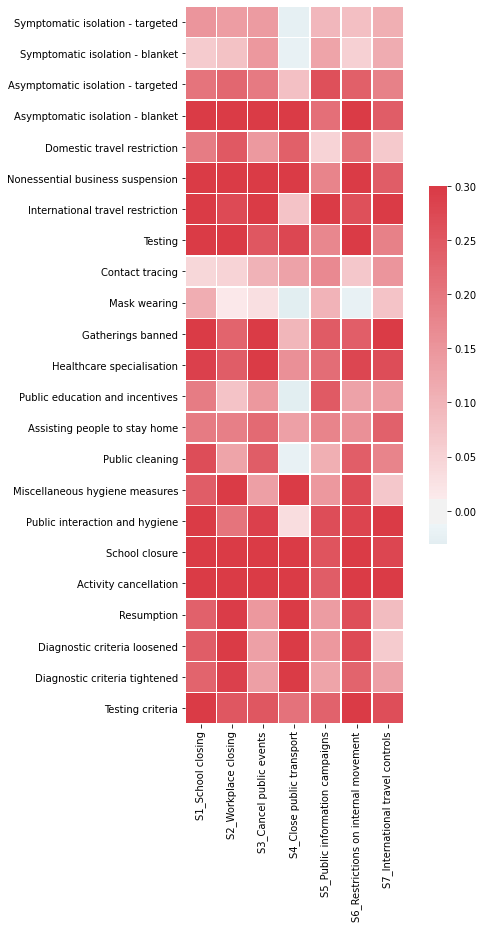

In [424]:
f, ax = plt.subplots(figsize=(8, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(co, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig('CGRT_FD_corr.svg')

In [372]:
compare

,Country,Date,Asymptomatic isolation - blanket,Domestic travel restriction,Public interaction and hygiene,Public education and incentives,Gatherings banned,Activity cancellation,Nonessential business suspension,School closure
5,Australia,2020-01-01,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
6,Austria,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Belgium,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Bulgaria,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Belarus,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10552,South Korea,2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10555,Romania,2020-03-31,2.0,2.0,NaN,2.0,1.0,NaN,2.0,1.0
10556,Russia,2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
10558,Serbia,2020-03-31,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0


In [422]:
len(feats)

7370

In [423]:
len(db)

1703

In [427]:
compare[compare.columns[2:]] = compare[compare.columns[2:]]/compare[compare.columns[2:]].max(0)

In [429]:
compare[['Country',
         'Date',
         'Asymptomatic isolation - blanket',
         'Public interaction and hygiene',
         'Gatherings banned',
         'Nonessential business suspension',
         'School closure']].to_csv('oxford_dataset_comparison.csv')